# Deep Learning

In this Question you will build an image classifier and also use a pre-trained one.

We will work with the __CIFAR10__ dataset that consists of 60,000 32x32x3 color images from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.




**IMPORTANT**

Before we start running our Colab, remember to make a copy of this notebook on your own Drive.

While developing the code/debugging, connect to **CPU**, so that you don't use up all of your GPU resources. After making sure that the code is running, you can connect to GPU and run your full experiments there.

Another thing we'll do: we are going to use GPU to speed up our calculations! Go to __Runtime__, and click in __Change Runtime Type__. There, select __GPU__ as hardward accelerator.

Please read carefully each cell, both markdown and code, from this notebook, and fill in the blanks and answer the questions. The objective is to have a functional model that can be run by executing each cell of the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

2024-11-03 21:21:09.513361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730665269.523971   66281 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730665269.527213   66281 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 21:21:09.538267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Obtain dataset

CIFAR10 is a very famous benchmark dataset and is readily available in the `tensorflow_datasets` library, which is a library that contains many datasets ready to be used with Keras.


In [3]:
import tensorflow_datasets as tfds

ds_name = "cifar10"

# Get the dataset (extract)
# We will split the training dataset to get a validation set
(train_dataset, validation_dataset), info = tfds.load(ds_name,
                    split=["train[:80%]", "train[80%:]"],
                    batch_size = 32,
                    as_supervised=True,
                    with_info = True
                    )

test_dataset, info_test = tfds.load(ds_name,
                    split="test",
                    batch_size = 32,
                    as_supervised=True,
                    with_info = True
                    )

I0000 00:00:1730665270.834053   66281 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22354 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6


## Preprocessing

Now that we have obtained the data, let's do the preprocessing.



2024-11-03 21:21:11.025989: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-11-03 21:21:11.216373: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-03 21:21:11.245664: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


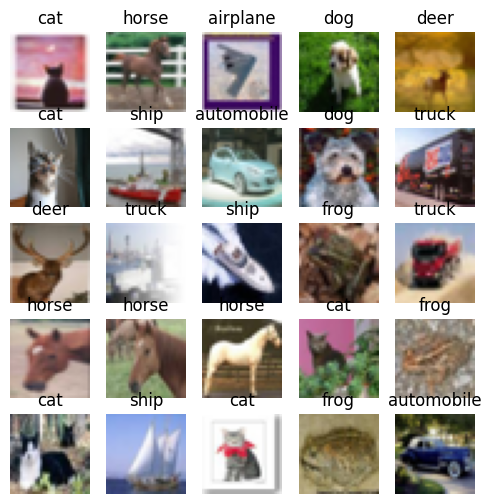

In [4]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(2):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    # plt.title(int(labels[i]))
    plt.axis("off")

## Data Augmentation
 We'll make the data augmentation as a layer of our model.

In [5]:
# Create a data augmentation layer that flips the images horizontally and
# rotates them randomly

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2024-11-03 21:21:11.743285: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2024-11-03 21:21:13.066317: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


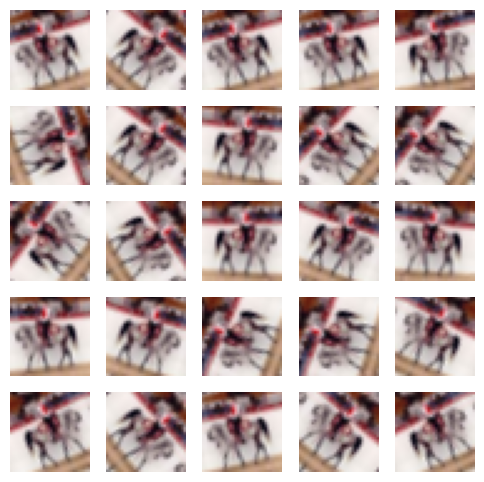

In [6]:
# Showcase the results
# Your output should resemble what you see now

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(6, 6))
  first_image = image[0]
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model

Create your own CNN model from scratch.


Keep in mind, it is possible your model will have a poor performance. Don't worry, CIFAR is not that a trivial dataset. A priori, a pretty naïve CNN should still get at least 60% accuracy on the validation set but won't likely exceed 70% accuracy.

### 1. Build your own CNN

Experiment with the architecture of your network, add/remove dense or convolutional layers, increase the number of units, change the kernel size, play with the parameters, increase the number of epochs, or anything else to boost your performance. Try to keep the training phase of your model less than an hour long (and again, remember to change the runtime to GPU as we explained at the beggining).

In [7]:
# Import the layers we will need to build a CNN
# We'll need convolutional and max-pooling layers for the first part of the CNN
# We need to flatten the output of the convolutional layers
# We need dense hidden layers and one dense layer as output

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
# Let's begin with a small CNN with few parameters just to get something started
# Let's begin with 2 pairs of conv-maxpool layers with ~10-100 filters of 2x2
# One hidden layer with ~100-1000 units
# Also, let's add dropout after the hidden layer

img_size = (32, 32)
num_classes = info.features["label"].num_classes
hidden_units = Dense(128, activation='relu')
dropout = Dropout(0.5)

# Use a sequential model
model = keras.models.Sequential()
##### YOUR MODEL #####
##### Think of the softmax activation function for your last layer! #####

model.add(keras.Input(shape=img_size + (3,)))
# model.add(data_augmentation)
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, kernel_size=(9, 9), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(dropout)
model.add(Dense(num_classes, activation="softmax"))
#######################

In [9]:
# Let's see the summary of the model. How many trainable variables are there?

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 128)      │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,348,618 (5.14 MB)

 Trainable params: 1,348,618 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

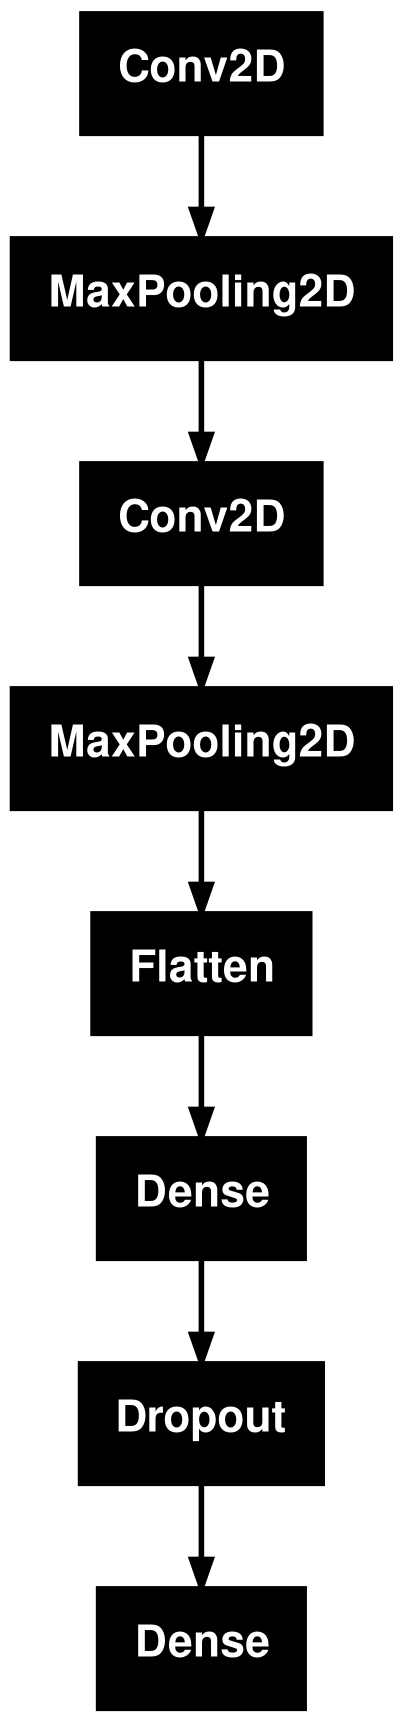

In [10]:
# Let's show the CNN.

keras.utils.plot_model(model)

In [11]:
# Now we proceed to compile the model
# Pick the right loss for this context (multi-class classification, it would be a good idea to see what the target looks like)
# Feel free to use any optimizer (adam, rsmprop, etc)
# As metric include accuracy

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer="adam",
              metrics = ["accuracy"])

In [12]:
# Finally, let's fit the model

# We'll use a callback to make the model learn the best epoch in validation
# No need to change anything from the callback
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='my_first_cnn_from_scratch.keras',
    save_best_only=True,
    monitor='val_accuracy')]

# Use the trainig data to train and the validation data to validate
# Add early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
callbacks.append(early_stopping)

EPOCHS  = 20
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/20


I0000 00:00:1730665274.053739   66543 service.cc:148] XLA service 0x55fadf92ee70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730665274.053759   66543 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-11-03 21:21:14.072421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730665274.145423   66543 cuda_dnn.cc:529] Loaded cuDNN version 90300


 106/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1284 - loss: 30.3379

I0000 00:00:1730665275.357831   66543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1238/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2513 - loss: 6.1746

2024-11-03 21:21:17.361113: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2521 - loss: 6.1371 - val_accuracy: 0.4398 - val_loss: 1.5784
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4356 - loss: 1.6070 - val_accuracy: 0.4865 - val_loss: 1.4590
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4944 - loss: 1.4589 - val_accuracy: 0.5154 - val_loss: 1.4385
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5390 - loss: 1.3367 - val_accuracy: 0.5333 - val_loss: 1.3575
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5644 - loss: 1.2530 - val_accuracy: 0.5635 - val_loss: 1.3510
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5891 - loss: 1.2048 - val_accuracy: 0.5820 - val_loss: 1.2650
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6135 - loss: 1.1174 - val_accuracy: 0.5730 - val_loss: 1.3090
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6342 - loss: 1.0583 - val_accurac

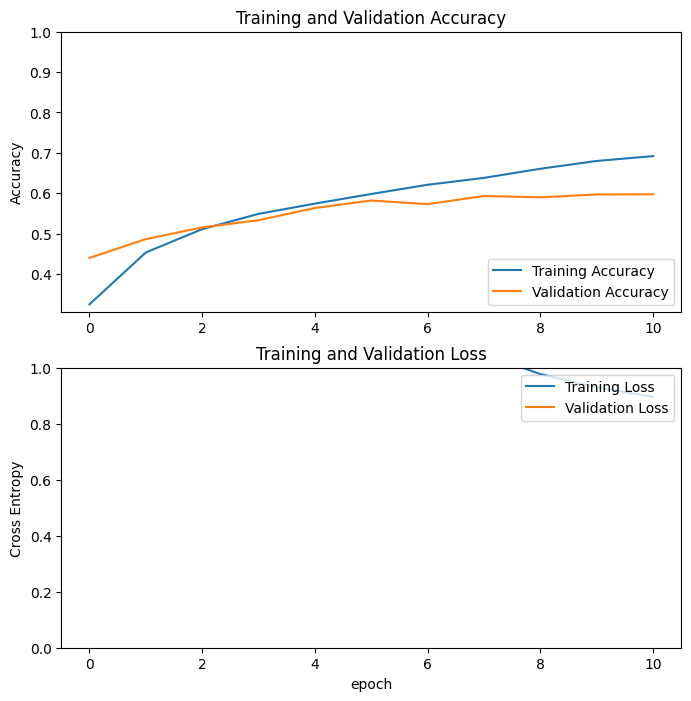

In [13]:
# Let's check the learning curve
# Rerun this after you perform the training
# The output should have two plots as below

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
# Finally, evaluate your model on the test data and report the results

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

 88/313 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.6055 - loss: 1.2043

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.5860 - loss: 1.2392
Test accuracy : 0.5730999708175659


Where did your model make mistakes? What can you say about the model based on the erros?

Build a confusion matrix, or show a subsample of examples from test data where the model made a mistake.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


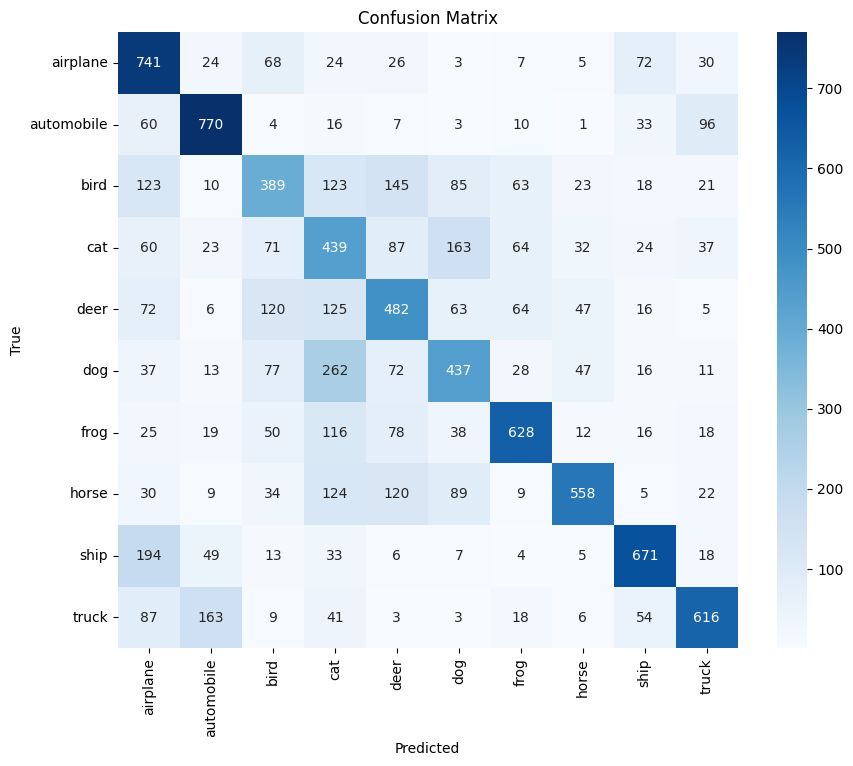

2024-11-03 21:21:39.111732: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


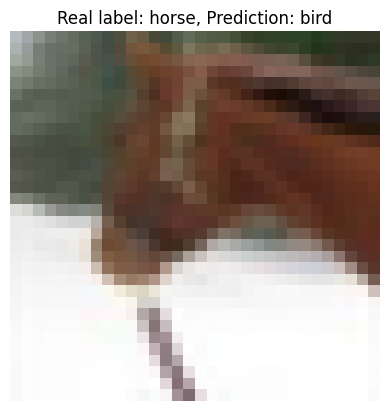

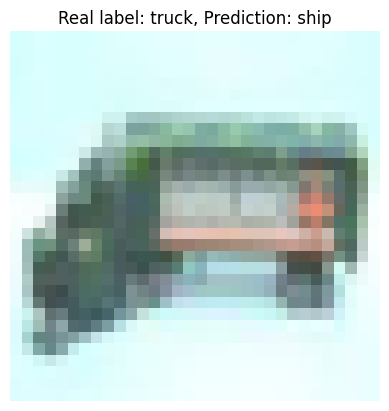

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check where you made errors
# This will show you a few examples where the model made errors

predictions = model.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

# Get true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

for images, labels in test_dataset.take(1):
    for i in range(4):
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        prediction = predictions[i]
        if prediction != label:
            plt.figure()
            plt.imshow(image)
            plt.title(f"Real label: {class_names[label]}, Prediction: {class_names[prediction]}")
            plt.axis("off")

### 2. Use Transfer Learning


Use Transfer Learning to import an existing model and use it as the base model for your the CIFAR classifier.

Try using EfficientNet-b0, or any other model of your choice. Be mindful that some models may not accept an image size of only 32x32x3 and that transfer learning may require you to additionally resize each image from 32x32x3 to something larger.

In [16]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [17]:
# To work properly, the pretrained network expect an image of about the same size it was trained on.
# CIFAR10 is of shape 32x32x3, while ImageNet is generally reshaped as 224x224x3.
# Play a little bit with the SIZE parameter of the resizing.
# Maybe 32 won't work that well, in that case try another value ;)
SIZE = 128

base_model = keras.applications.vgg16.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(SIZE, SIZE, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
# TODO 1 line
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(32, 32, 3))

resize_layer = keras.layers.Resizing(SIZE, SIZE)
x = resize_layer(inputs) #Necessary to resize each image

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
# x = data_augmentation(x)

# Pre-trained network weights often require that input be scaled
# from (0, 255) to a range of (-1., +1.). the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

# TODO: 1 line, ADD THE GLOBALAVERAGEPOOL LAYER
x = keras.layers.GlobalAveragePooling2D()(x)
# TODO: 1 line, ADD DROPOUT IF YOU WANT
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10, activation = "softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# Performance of the model
# TODO
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='transfer_learning.keras',
    save_best_only=True,
    monitor='val_accuracy')]

    
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
callbacks.append(early_stopping)

EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.4364 - loss: 1.7315 - val_accuracy: 0.6633 - val_loss: 1.0815
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6483 - loss: 1.0823 - val_accuracy: 0.6955 - val_loss: 0.9448
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6751 - loss: 0.9747 - val_accuracy: 0.7103 - val_loss: 0.8858
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6850 - loss: 0.9269 - val_accuracy: 0.7214 - val_loss: 0.8504
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6966 - loss: 0.8974 - val_accuracy: 0.7298 - val_loss: 0.8252
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7030 - loss: 0.8781 - val_accuracy: 0.7308 - val_loss: 0.8091
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7061 - loss: 0.8697 - val_accuracy: 0.7318 - val_loss: 0.7992
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7067 -

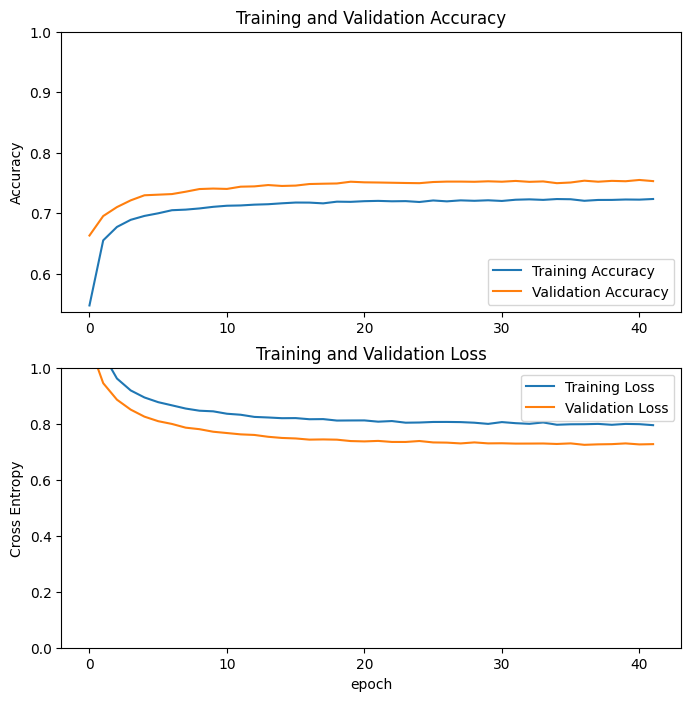

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7461 - loss: 0.7350
Test accuracy : 0.7398999929428101


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


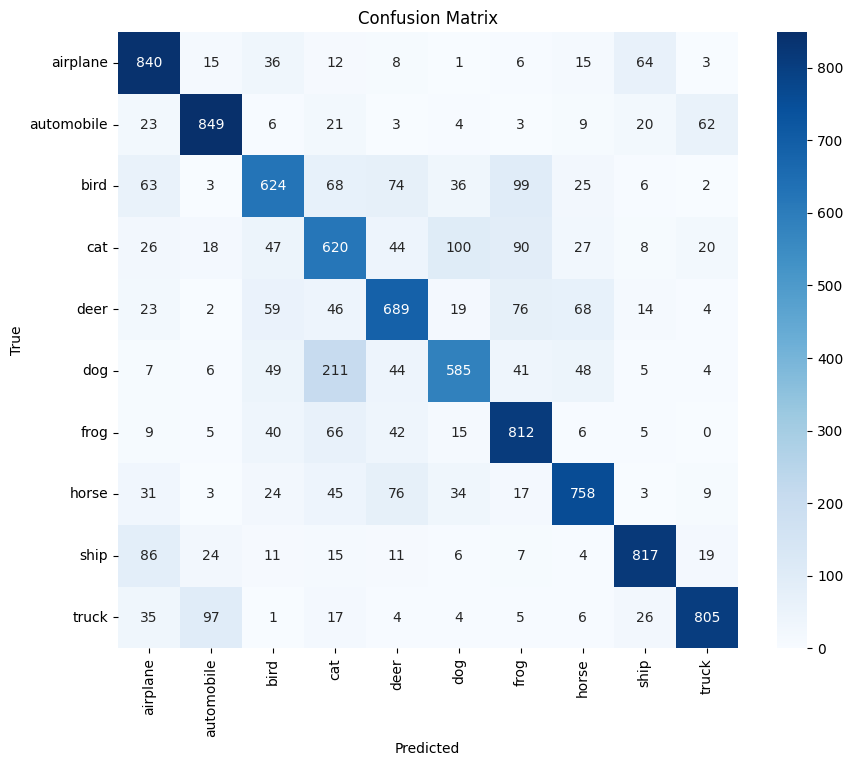

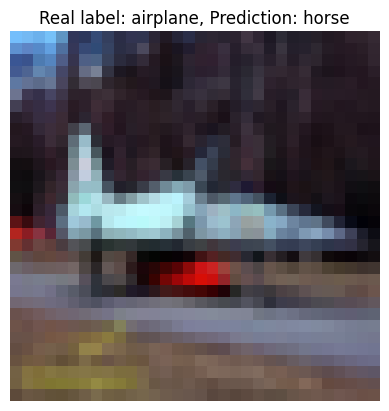

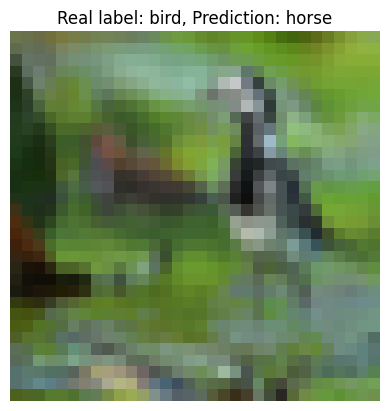

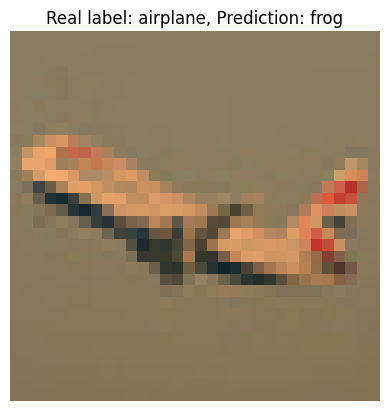

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check where you made errors
# This will show you a few examples where the model made errors

predictions = model.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

# Get true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

for images, labels in test_dataset.take(2):
    for i in range(3):
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        prediction = predictions[i]
        if prediction != label:
            plt.figure()
            plt.imshow(image)
            plt.title(f"Real label: {class_names[label]}, Prediction: {class_names[prediction]}")
            plt.axis("off")